In [1]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM, BatchNormalization, Conv1D

Using TensorFlow backend.


In [24]:
def get_lstm_model(
    shape_input,
    lstm_units=128,
    lstm_input_dropout=0,
    lstm_one_dropout=0.2,
    lstm_two_dropout=0.2,
    dense_one_units=30,
    dense_one_dropout=0.2,
    conv1d_units=196,
    conv1d_kernel_size=15,
    conv1d_stride=4,
    conv1d_dropout=0.2,
):
    
    X_input = Input(shape_input, name="input")
    X = X_input
    
    if conv1d_units:
        X = Conv1D(conv1d_units, conv1d_kernel_size, strides=conv1d_stride, name="conv")(X)
        X = BatchNormalization(name="conv1d_bn")(X)
        X = Activation('relu', name="conv1d_activation")(X)
        if conv_dropout:
            X = Dropout(conv_dropout, name="conv1d_dropout")(X)
    
    if lstm_input_dropout:
        X = Dropout(lstm_input_dropout, name="lstm_input_dropout")(X)
    X = LSTM(lstm_units, return_sequences=True, name="lstm_one")(X)
    if lstm_one_dropout:
        X = Dropout(lstm_one_dropout, name="lstm_one_dropout")(X)
    X = BatchNormalization(name="lstm_one_bn")(X)
    
    X = LSTM(lstm_units, name="lstm_two")(X)
    if lstm_two_dropout:
        X = Dropout(lstm_two_dropout, name="lstm_two_dropout")(X)
    X = BatchNormalization(name="lstm_two_bn")(X)
    
    X = Dense(dense_one_units, activation=None, name="dense_one")(X)
    if dense_one_dropout:
        X = Dropout(dense_one_dropout, name="dense_one_dropout")(X)
    X = BatchNormalization(name="dense_one_bn")(X)
    X = Activation('relu', name="dense_one_activation")(X)
    
    X = Dense(2, activation='softmax', name="output")(X)
    
    return Model(inputs=X_input, outputs=X)

In [25]:
NUM_SAMPLES = 10
NUM_FEATURES = 15
SAMPLE_SIZE = 128
lstm_model = get_lstm_model((NUM_SAMPLES, NUM_FEATURES * SAMPLE_SIZE), conv1d_units=0)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 1920)          0         
_________________________________________________________________
lstm_one (LSTM)              (None, 10, 128)           1049088   
_________________________________________________________________
lstm_one_dropout (Dropout)   (None, 10, 128)           0         
_________________________________________________________________
lstm_one_bn (BatchNormalizat (None, 10, 128)           512       
_________________________________________________________________
lstm_two (LSTM)              (None, 128)               131584    
_________________________________________________________________
lstm_two_dropout (Dropout)   (None, 128)               0         
_________________________________________________________________
lstm_two_bn (BatchNormalizat (None, 128)               512 

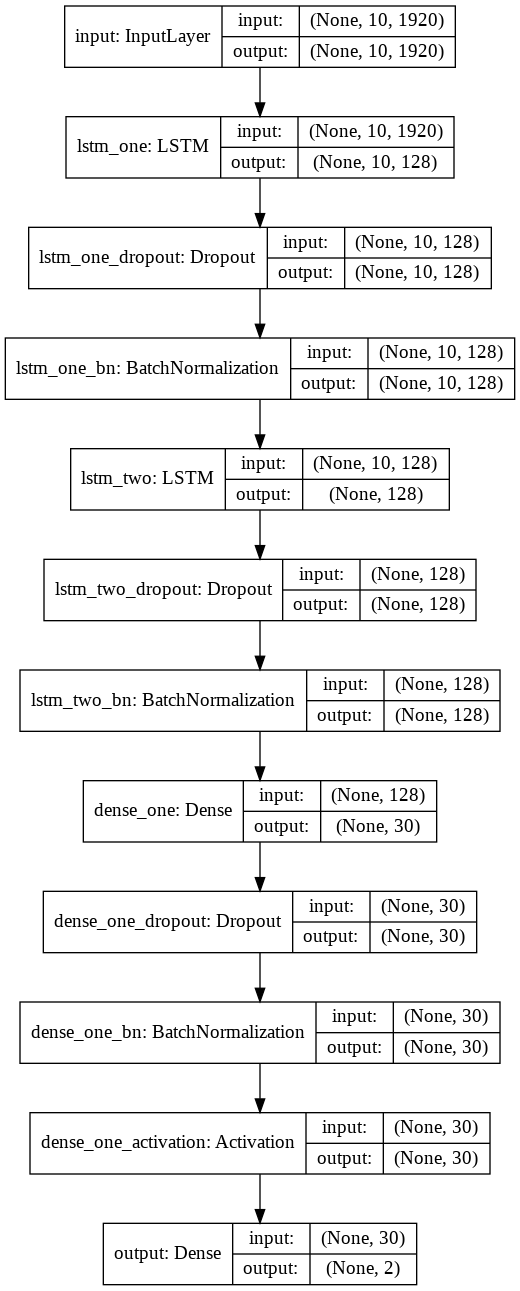

In [26]:
from keras.utils import plot_model
lstm_model.summary()
plot_model(lstm_model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

In [15]:
from keras.optimizers import Adam

def compile_model(
    model,
    learning_rate=0.01,
    beta_one=0.9,
    beta_two=0.999,
    decay=0.01,
):
    opt = Adam(learning_rate, beta_one, beta_two, decay)
    model.compile(opt, loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
LEARNING_RATE=0.1
BETA_ONE=0.9
BETA_TWO=0.999
DECAY=0.01
compile_model(lstm_model, LEARNING_RATE, BETA_ONE, BETA_TWO, DECAY)